# Metaheuristics similarity analysis using MSA

This example is a tutorial and a showcase of frameworks capabilities and features.

### Import tools and libraries

In [6]:
# Analysis tools
from msa.tools.metaheuristics_similarity_analyzer import MetaheuristicsSimilarityAnalyzer
from msa.tools.meta_ga import MetaGAFitnessFunction, MetaGA

# Diversity metrics
from msa.diversity_metrics.individual_diversity.idt import IDT
from msa.diversity_metrics.individual_diversity.ifiqr import IFIQR
from msa.diversity_metrics.individual_diversity.ifm import IFM
from msa.diversity_metrics.individual_diversity.isi import ISI
from msa.diversity_metrics.population_diversity.dpc import DPC
from msa.diversity_metrics.population_diversity.fdc import FDC
from msa.diversity_metrics.population_diversity.pfm import PFM
from msa.diversity_metrics.population_diversity.pfsd import PFSD

# Optimization problem from the NiaPy framework
from niapy.problems.schwefel import Schwefel

# Other tools
import os
import matplotlib
matplotlib.use("inline")

# Define constants for later use
base_archive_path = "archive"
msa_pkl_filename = "msa_example"

### Define genespaces used for the analysis
Name of the algorithm can be a string corresponding with the name of the algorithm class from the `niapy.algorithms` framework, or a class inheriting from the niapy `Algorithm` class. Names of the hiperparameters must correspond with the nemes of selected algorithm constructor arguments.

---
**_TIP:_** In the folowing block are some gene space examples to use in the folowing code. Try defining gene spaces for other alogorithms from niapy framework.

---
**_NOTE:_** Make sure that algorithm returns `sorted_idx` as the resut of `argsort` under `Additional arguments` in `run_iteration` method if it is using sorting. Some algorithms will require adaptation for the analysis to work as intended. See `msa.algorithms.fa` as an example.

---

In [7]:
from msa.algorithms.pso import ParticleSwarmAlgorithm
from msa.algorithms.fa import FireflyAlgorithm
from niapy.algorithms.basic.de import DifferentialEvolution

PSO_gene_space = {
    ParticleSwarmAlgorithm: {
        "c1": {"low": 0.01, "high": 2.5, "step": 0.01},
        "c2": {"low": 0.01, "high": 2.5, "step": 0.01},
        "w": {"low": 0.0, "high": 1.0, "step": 0.01},
    }
}

BA_gene_space = {
    "BatAlgorithm": {
        "loudness": {"low": 0.01, "high": 1.0, "step": 0.01},
        "pulse_rate": {"low": 0.01, "high": 1.0, "step": 0.01},
        "alpha": {"low": 0.9, "high": 1.0, "step": 0.001},
        "gamma": {"low": 0.0, "high": 1.0, "step": 0.01},
    }
}

FA_gene_space = {
    FireflyAlgorithm: {
        "alpha": {"low": 0.01, "high": 1.0, "step": 0.01},
        "beta0": {"low": 0.01, "high": 1.0, "step": 0.01},
        "gamma": {"low": 0.0, "high": 1.0, "step": 0.001},
        "theta": {"low": 0.95, "high": 1.0, "step": 0.001},
    }
}

DE_gene_space = {
    DifferentialEvolution: {
        "differential_weight": {"low": 0.01, "high": 1.0, "step": 0.01},
        "crossover_probability": {"low": 0.01, "high": 1.0, "step": 0.01},
    }
}


### Choose which diversity metrics to use for the analysis
* Individual diversity metrics are available in `msa.diversity_metrics.individual_diversity` and
* Popuation diversity metrics are available in `msa.diversity_metrics.population_diversity`.
* To implement new diversity metrics the class must inherit from either `PopDiversityMetric` or `IndivDiversityMetric` availabe in `msa.tools.optimization_data`.

In [8]:
OPTIMIZATION_PROBLEM = Schwefel(dimension=20)

POP_DIVERSITY_METRICS = [
    DPC(OPTIMIZATION_PROBLEM),
    FDC(OPTIMIZATION_PROBLEM, [420.968746], True),
    PFSD(),
    PFM(),
]
INDIV_DIVERSITY_METRICS = [
    IDT(),
    ISI(),
    IFM(),
    IFIQR(),
]

### Define a MetaGA instance used for the analysis
* Set `fitness_function_type` to `MetaGAFitnessFunction.TARGET_PERFORMANCE_SIMILARITY`.
* Arguments starting with `ga_` correspond with the arguments of the class `GA` from `pygad` module.
* Set `gene_space` to gene space of the algorithm to be optimized.

---
**_TIP:_** Try out gene spaces defined above to analyze other algorithms.

---

**_NOTE:_** MetaGA in this configuration can be used as a standalone tool, however to get the most out of the analysis it is recommended to use it in combination with `MetaheuristicsSimilarityAnalyzer`.

---

In [9]:
meta_ga = MetaGA(
    fitness_function_type=MetaGAFitnessFunction.TARGET_PERFORMANCE_SIMILARITY,
    ga_generations=3,
    ga_solutions_per_pop=5,
    ga_percent_parents_mating=60,
    ga_parent_selection_type="tournament",
    ga_k_tournament=2,
    ga_crossover_type="uniform",
    ga_mutation_type="random",
    ga_crossover_probability=0.9,
    ga_mutation_num_genes=1,
    ga_keep_elitism=1,
    gene_space=PSO_gene_space,
    pop_size=30,
    max_evals=10000,
    num_runs=30,
    problem=OPTIMIZATION_PROBLEM,
    pop_diversity_metrics=POP_DIVERSITY_METRICS,
    indiv_diversity_metrics=INDIV_DIVERSITY_METRICS,
)

### Define a MSA instance and start the analysis
MetaheuristicsSimilarityAnalyzer accepts the previously defined MetaGA under `meta_ga` and the gene space of the reference metaheuristic under `target_gene_space`.

Argument options of the `run_similarity_analysis` method:
* Setting `export` to `True` produces a .pkl file which can be imported for later use.
* Setting `get_info` to `True` produces a workflow diagram displaying useful information.
* Setting `generate_dataset` to `True` generates a dataset which enables the calculation of similarity metrics.
* Setting `calculate_similarity_metrics` to `True` triggers calculation of similarity metrics.

---
**_NOTE:_** Use different `prefix` value for future experiments to prevent overwriting the existing export. It can also be left unspecified, as per default, to use the current datetime value.

---

In [10]:
msa = MetaheuristicsSimilarityAnalyzer(
    meta_ga=meta_ga,
    target_gene_space=DE_gene_space,
    base_archive_path=base_archive_path
)

msa.run_similarity_analysis(
    num_comparisons=2,
    get_info=True,
    generate_dataset=True,
    num_runs=150,
    calculate_similarity_metrics=True,
    export=True,
    prefix="example",
    pkl_filename=msa_pkl_filename,
)


======> 0/1_COMPARISON_DE-PSO <======
|-> DE target = [0.8  0.73]
1_Meta-GA_generation
|-> Fitness  = 0.6463895545294058
|-> Solution = [0.11 2.42 0.9 ]
2_Meta-GA_generation
|-> Fitness  = 0.6463895545294058
|-> Solution = [0.11 2.42 0.9 ]
3_Meta-GA_generation
|-> Fitness  = 0.6463895545294058
|-> Solution = [0.11 2.42 0.9 ]
Time elapsed: 00:00:44.63


Cleaning up meta-GA temporary data...
PSO best solution: [0.11 2.42 0.9 ]



======> 1/1_COMPARISON_DE-PSO <======
|-> DE target = [0.27 0.72]
1_Meta-GA_generation
|-> Fitness  = 0.6316427911382717
|-> Solution = [0.68 0.29 0.98]
2_Meta-GA_generation
|-> Fitness  = 0.6316427911382717
|-> Solution = [0.68 0.29 0.98]
3_Meta-GA_generation
|-> Fitness  = 0.6588059187537598
|-> Solution = [0.68 0.29 0.92]
Time elapsed: 00:00:53.82


Cleaning up meta-GA temporary data...
PSO best solution: [0.68 0.29 0.92]

Analysis completed in: 00:01:38.48
Generating dataset...
Calculating similarity metrics...
Exporting .pkl file...

All done in: 00:04:54.55


### Import MSA instance

Setting `export` argument to `True` in previous step enables importing via the static method `MetaheuristicsSimilarityAnalyzer.import_from_pkl`.

---
**_NOTE:_** Make sure to provide the correct path to the exported .pkl file.

---

In [11]:
pkl_path = os.path.join(base_archive_path, "example_DE-PSO_Schwefel", msa_pkl_filename)
print(pkl_path)
imported_msa = MetaheuristicsSimilarityAnalyzer.import_from_pkl(pkl_path)

archive/example_DE-PSO_Schwefel/msa_example


### Export results of the analysis to LaTex and generate a PDF

In [12]:
imported_msa.export_results_to_latex(generate_pdf=True, filename="MSA_example_results")

### Plot solution evolution for each comparison
Plot can be shown for all solutions or the best solution in each generation only.

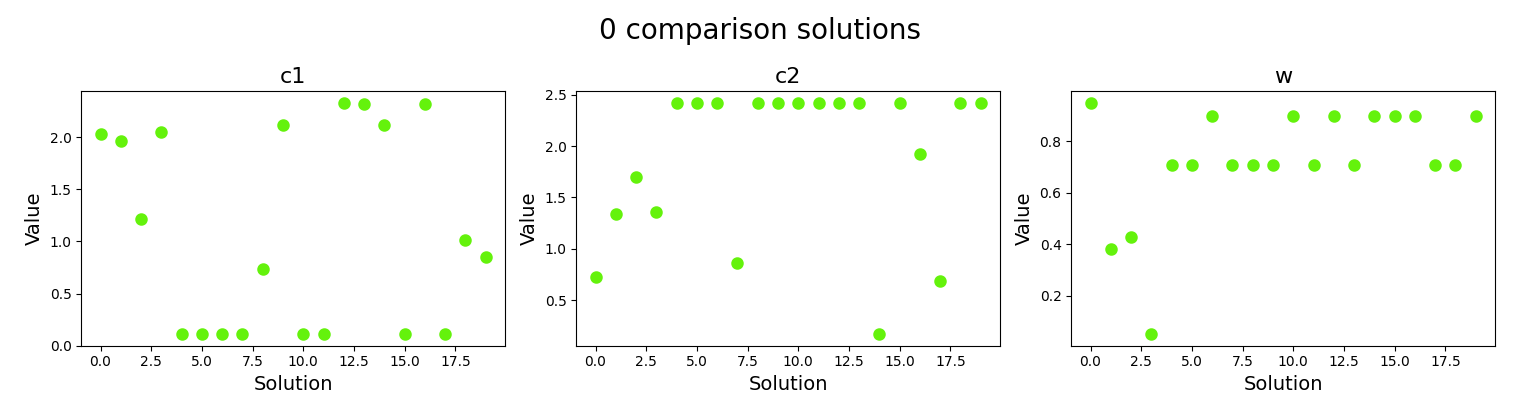

In [13]:
imported_msa.plot_solutions(comparison_index=0, filename="meta_ga_all_solutions_evolution", all_solutions=True)

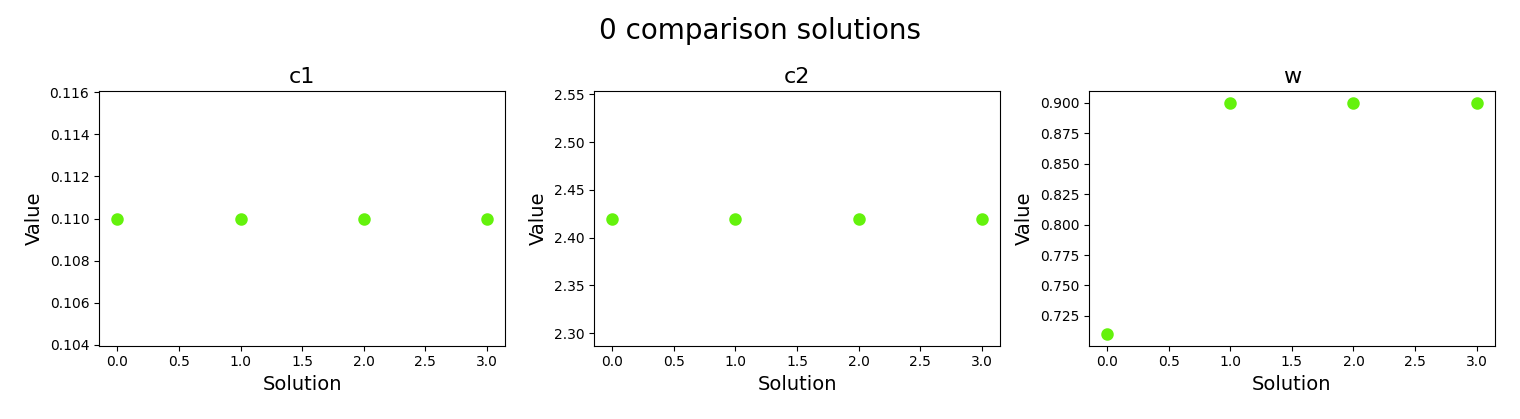

In [14]:
imported_msa.plot_solutions(comparison_index=0, filename="meta_ga_best_solutions_evolution")

### Plot fitenss

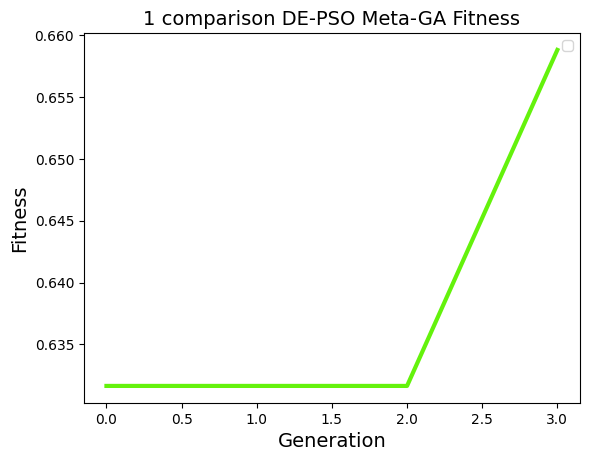

In [15]:
imported_msa.plot_fitness(comparison_index=1, filename="meta_ga_fitness_plot")

### Plot diversity metrics
plots can be shown for individual and population diverity metrics. Plots show diversity metrics of both metaheuristics.

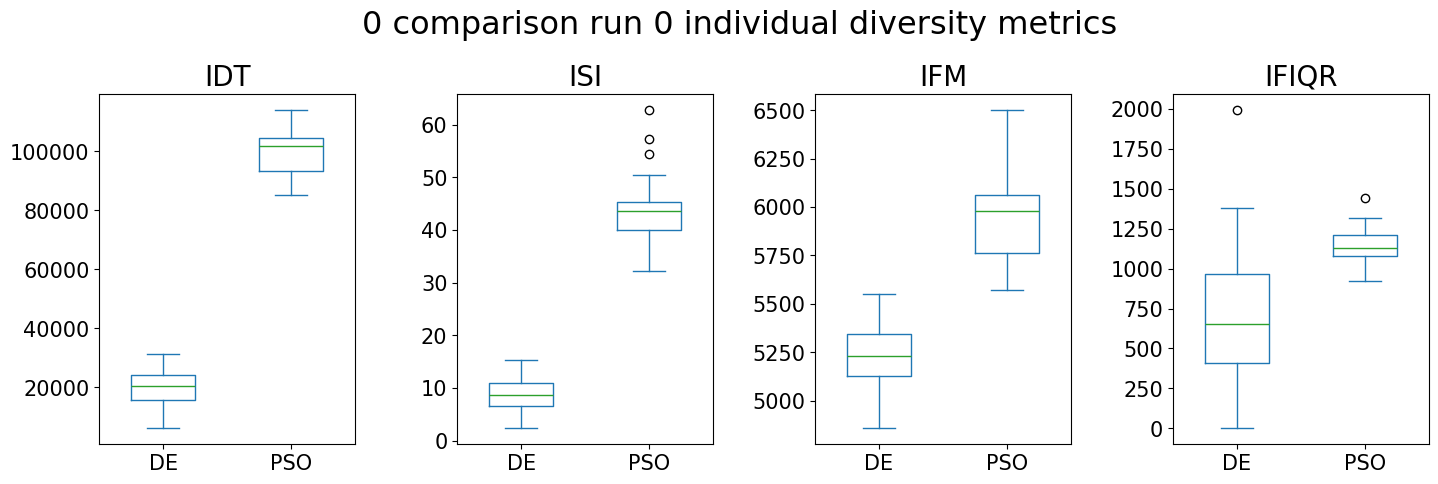

In [16]:
imported_msa.indiv_diversity_metrics_comparison(comparison_index=0, run_index=0)

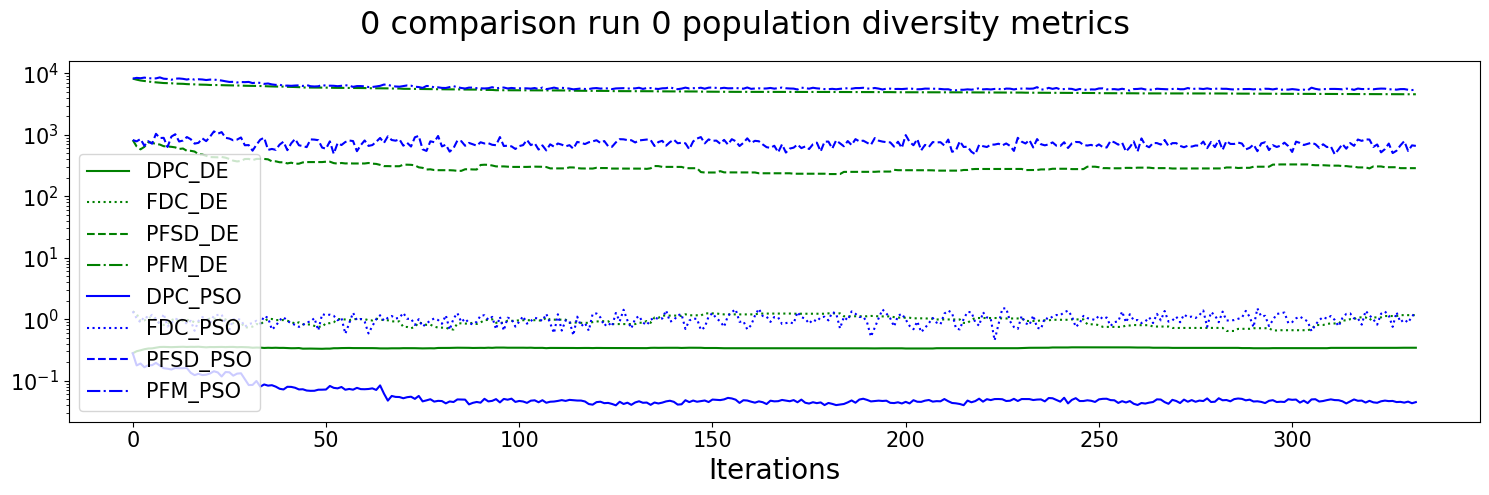

In [17]:
imported_msa.pop_diversity_metrics_comparison(comparison_index=0, run_index=0)

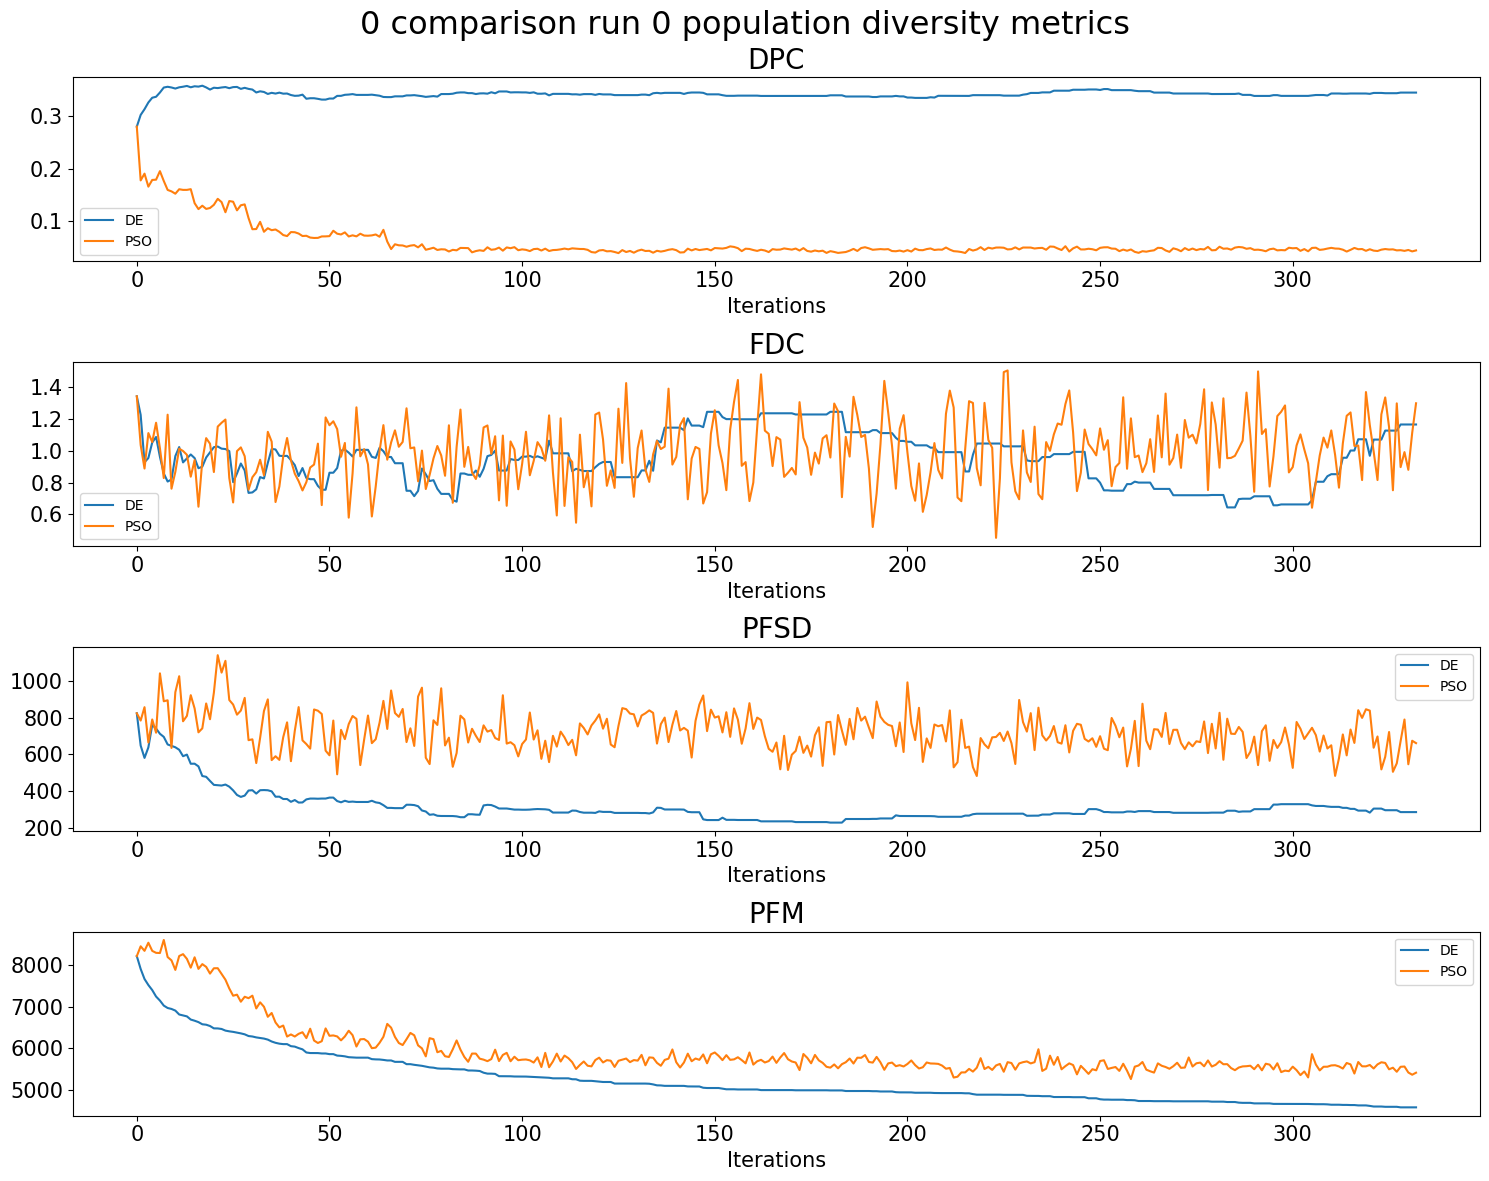

In [18]:
imported_msa.pop_diversity_metrics_comparison(comparison_index=0, run_index=0, separate=True)